# train the yolo
## loss: loss layer, sigmoid output all demission

In [1]:
%load_ext autoreload
%autoreload 2
from keras import applications, losses
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, Model, K
from keras.layers import Lambda, Input, Dropout, Flatten, Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, concatenate, GlobalAveragePooling2D, MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.metrics import top_k_categorical_accuracy
from keras.utils import Progbar, GeneratorEnqueuer
from keras.applications import imagenet_utils
import tensorflow as tf
import numpy as np
import os
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import inspect
import matplotlib.patches as patches

from utils import mkdirp, load_base, load_feature, anno_file_to_rect, anno_file_to_yolo_y, get_image_size, img2data

from yolo_data_generator import YoloDataGenerator
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# build the feature data
train_data_dir = './dogs/images/train'
val_data_dir = './dogs/images/val'
round = .1
nb_train_samples = NB_TRAIN_SAMPLES = int(16494 * round // 1) ## copy from split script
nb_val_samples = NB_VAL_SAMPLES = int(4086 * round //1) ## copy from split script
epochs = 50
batch_size = 16
n_classes = 120
img_width, img_height = 224, 224

base_model_name = "mn"
GRIDS = {"inception": (5,5), "mn": (7,7)}
grid = GRIDS[base_model_name]

mkdirp(base_model_name)

In [3]:
images_root = "/Users/xuan/work/dataset/dogs/images"
annotations_root = "/Users/xuan/work/dataset/dogs/annotations"
train_images_root = images_root + "/train"
val_images_root = images_root + "/val"
train_annotations_root = annotations_root + "/train"
val_annotations_root = annotations_root + "/val"

In [4]:
# 加载feature数据到内存
val_features, val_labels = load_feature(base_model_name, "val-dogs-120")
print "shapes for val feature",val_features.shape, val_labels.shape

train_features, train_labels = load_feature(base_model_name, "train-dogs-120")
print "shapes for train feature ", train_features.shape, train_labels.shape

shapes for val feature (400, 7, 7, 1024) (400, 245)
shapes for train feature  (1648, 7, 7, 1024) (1648, 245)


In [5]:
train_features.shape[1:]

(7, 7, 1024)

In [5]:
def yolo_loss(y_, y, confidence_loss_weight = 1.0, location_loss_weight = 1.0, noobj_loss_weight = 1.0, grid = (5,5), batch_size = 32):
  # reshape to split into boxes
  y_ = K.reshape(y_, [-1, grid[0] * grid[1], 5])
  y = K.reshape(y, [-1,  grid[0] * grid[1], 5])

  objects_matcher = y[..., 0:1]
  objects_boxes_coord = y[..., 1:3] * objects_matcher
  objects_boxes_coord_ = y_[..., 1:3] * objects_matcher
  boxes_loss = K.sum(K.square(objects_boxes_coord - objects_boxes_coord_))

  objects_boxes_size = y[..., 3:5] * objects_matcher
  objects_boxes_size_ = y_[..., 3:5] * objects_matcher
  boxes_loss += K.sum(K.square((objects_boxes_size) - (objects_boxes_size_)))

  objects_confidences = y[..., 0:1]
  objects_confidences_ = y_[..., 0:1] * objects_confidences
  object_confidence_loss = K.sum(K.square(objects_confidences - objects_confidences_))

  non_objects_confidences_ = y_[..., 0:1] * (1.0 - y[..., 0:1])
  non_object_confidence_loss = K.sum(K.square(non_objects_confidences_))
  
  total_loss = boxes_loss * location_loss_weight + object_confidence_loss * confidence_loss_weight + non_object_confidence_loss * noobj_loss_weight
  return total_loss

In [15]:
# build the yolo regression model
feature_input = Input(shape=train_features.shape[1:], name = 'feature_input')
x = feature_input
batch_size = 32
n_outputs = grid[0] * grid[1] * 5

x = Flatten()(x)
x = Dropout(0.8)(x)
x = Dense(n_outputs, activation='sigmoid', name='predictions')(x)

boxes_input = Input(shape=(n_outputs,), name = "box_input")

model = Model(input = feature_input, output = x)

def the_yolo_loss(args):
    (y_, y) = args
    return yolo_loss(y_, y, confidence_loss_weight = 1.0, location_loss_weight = 5.0, noobj_loss_weight = 0.5, grid = grid, batch_size = 32)

model_loss_layer = Lambda(
            the_yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={})([x, boxes_input])

full_model = Model(input = [feature_input, boxes_input], output=model_loss_layer)

full_model.compile(loss={
                    'yolo_loss': lambda y_true, y_pred: y_pred
                },
              optimizer=optimizers.Adadelta())

full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, 7, 7, 1024)   0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 50176)        0           feature_input[0][0]              
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 50176)        0           flatten_2[0][0]                  
__________________________________________________________________________________________________
predictions (Dense)             (None, 245)          12293365    dropout_2[0][0]                  
__________________________________________________________________________________________________
box_input 

/Library/Python/2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("fe...)`
  
/Library/Python/2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("yo..., inputs=[<tf.Tenso...)`


In [16]:
# 直接输出结果，而不是使用一个layer做loss输出
feature_input = Input(shape=train_features.shape[1:], name = 'feature_input')
x = feature_input
batch_size = 32
n_outputs = grid[0] * grid[1] * 5

x = Flatten()(x)
# x = Dropout(0.8)(x)
# x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.8)(x)
x = Dense(n_outputs, activation='sigmoid', name='predictions')(x)

boxes_input = Input(shape=(n_outputs,), name = "box_input")

direct_model = Model(input = feature_input, output = x)

def direct_yolo_loss(y_, y):
    print "shapes", y_.shape, y.shape
    return yolo_loss(y_, y, confidence_loss_weight = 1.0, location_loss_weight = 5.0, noobj_loss_weight = 0.5, grid = grid)

direct_model.compile(loss=direct_yolo_loss,
              optimizer=optimizers.Adadelta())

direct_model.summary()

# direct_model.fit(train_features, train_labels,
#           shuffle = True,
#           epochs=10,
#           batch_size=32,
#           validation_data=(val_features, val_labels)
#          )

shapes (?, ?) (?, 245)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50176)             0         
_________________________________________________________________
predictions (Dense)          (None, 245)               12293365  
Total params: 12,293,365
Trainable params: 12,293,365
Non-trainable params: 0
_________________________________________________________________


/Library/Python/2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("fe...)`
  from ipykernel import kernelapp as app


In [8]:
# train full model
total_params = "6400125"
id = "yolo-dogs-" + base_model_name + "-" + total_params
weights = base_model_name + "/" + id + ".h5"
print "weights", weights

if os.path.exists(weights):
  pass
checkpointer = ModelCheckpoint(filepath=id + "-{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=True)

full_model.fit([train_features,train_labels], np.zeros(len(train_labels)),
          shuffle = True,
          epochs=50,
          batch_size=32,
          validation_data=([val_features, val_labels], np.zeros(len(val_labels))),
          callbacks = [checkpointer])

weights mn/yolo-dogs-mn-6400125.h5
Train on 1648 samples, validate on 400 samples
Epoch 1/50
1648/1648 [==============================] - 9s 5ms/step - loss: 145.7025 - val_loss: 103.8895
Epoch 2/50
1648/1648 [==============================] - 8s 5ms/step - loss: 123.3354 - val_loss: 107.4930
Epoch 3/50
1648/1648 [==============================] - 8s 5ms/step - loss: 115.2955 - val_loss: 99.7879
Epoch 4/50
1648/1648 [==============================] - 8s 5ms/step - loss: 112.9769 - val_loss: 97.0853
Epoch 5/50
1648/1648 [==============================] - 9s 5ms/step - loss: 107.9719 - val_loss: 96.4608
Epoch 6/50
1648/1648 [==============================] - 8s 5ms/step - loss: 104.4849 - val_loss: 97.1585
Epoch 7/50
1648/1648 [==============================] - 9s 5ms/step - loss: 101.9347 - val_loss: 96.2384
Epoch 8/50
1648/1648 [==============================] - 9s 5ms/step - loss: 98.2255 - val_loss: 101.4067
Epoch 9/50
  96/1648 [>.............................] - ETA: 8s - loss: 103.

KeyboardInterrupt: 

In [7]:
mkdirp(base_model_name)
base_model, base_decoder, processor = load_base(base_model_name)
for layer in base_model.layers[:-1]:
    layer.trainable = False

In [8]:
# build full model
input = Input(shape=(img_width, img_height, 3), name = 'feature_input')
x = base_model(input)
x = direct_model(x)
completed_model = Model(input=input, output=x)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=Tensor("fe...)`
  """


In [9]:
train_generator = YoloDataGenerator(train_images_root, train_annotations_root)
val_generator = YoloDataGenerator(val_images_root, val_annotations_root)

In [10]:
def eval(completed_model = completed_model, val = True, JPEG_EXT = "JPEG", grid = (7,7)):
  batch_size = 4
  _, axs = plt.subplots(1, batch_size, figsize=(32, 32))
  for i in range(0, batch_size):
      ax = axs[i]
      ax.grid(b=None)
    
      total = len(val_generator.ids) if val else  len(train_generator.ids)
      sample = np.random.randint(0, total) if val else np.random.randint(0, total)
      generator = val_generator if val else train_generator
      image_file =  "{}/{}/{}.{}".format(images_root, "val" if val else "train", generator.ids[sample], JPEG_EXT)
      annotation_file = "{}/{}/{}".format(annotations_root ,"val" if val else "train", generator.ids[sample])

      (image_width, image_height) = get_image_size(annotation_file)

      ax.imshow(imread(image_file))

      rect = anno_file_to_rect(annotation_file)
      patch = patches.Rectangle((rect[0],rect[1]),rect[2] - rect[0],rect[3] - rect[1],linewidth=4,edgecolor='g',facecolor='none')
      ax.add_patch(patch)
      print "truth rect", rect

      # draw fitted model
      xs = img2data(image_file)
      # predict
      y_ = completed_model.predict(processor(xs), batch_size = 1)
      y_ = y_[0]
      cell = np.argmax(np.hstack(np.array([[1,0,0,0,0]] * (grid[0] * grid[1]))) * y_) / 5 
      print "confidences list as\n", np.round(100.0 * np.reshape(y_, (-1, grid[0], grid[1], 5))[..., 0]) / 100.0
      cell_x = cell % grid[1]
      cell_y = cell // grid[0]
      base = cell * 5
      gx = grid[0]
      gy = grid[1]
      cell_width = float(image_width) / gx
      cell_height = float(image_height) / gy

      (C, cx, cy, w, h) = y_[base: base + 5]
#       print "Max Confidence cx, cy, w, h", y_[base: base + 5]

      rect = np.array([(cell_x + cx - w * gx / 2.0 ) * cell_width, 
                (cell_y + cy - h * gy / 2.0 ) * cell_height, 
                w * image_width, 
                h * image_height])
#       print "rect", (rect[0], rect[1]), rect[2], rect[3]

      patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
      ax.add_patch(patch)
      center_x = (cell_x + cx) * cell_width
      center_y = (cell_y + cy) * cell_height

      # print center point
#       print "center x & y", center_x, center_y
      patch = patches.Circle((center_x, center_y), 6, linewidth=1,color='r',fill='full')
      ax.add_patch(patch)

      #draw center rect
      rect = (cell_x * cell_width, cell_y * cell_height, cell_width, cell_height)
      print "center cell", rect
      patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
#       ax.add_patch(patch)
  
  plt.show()

eval some train data
truth rect (77, 2, 309, 334)


/Library/Python/2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


confidences list as
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]]
center cell (214.28571428571428, 143.57142857142856, 71.42857142857143, 47.857142857142854)
truth rect (11, 15, 366, 315)
confidences list as
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]]
center cell (160.71428571428572, 138.0, 53.57142857142857, 46.0)
truth rect (0, 45, 499, 374)
confidences list as
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]]
center cell (214.28571428571428, 214.285714285

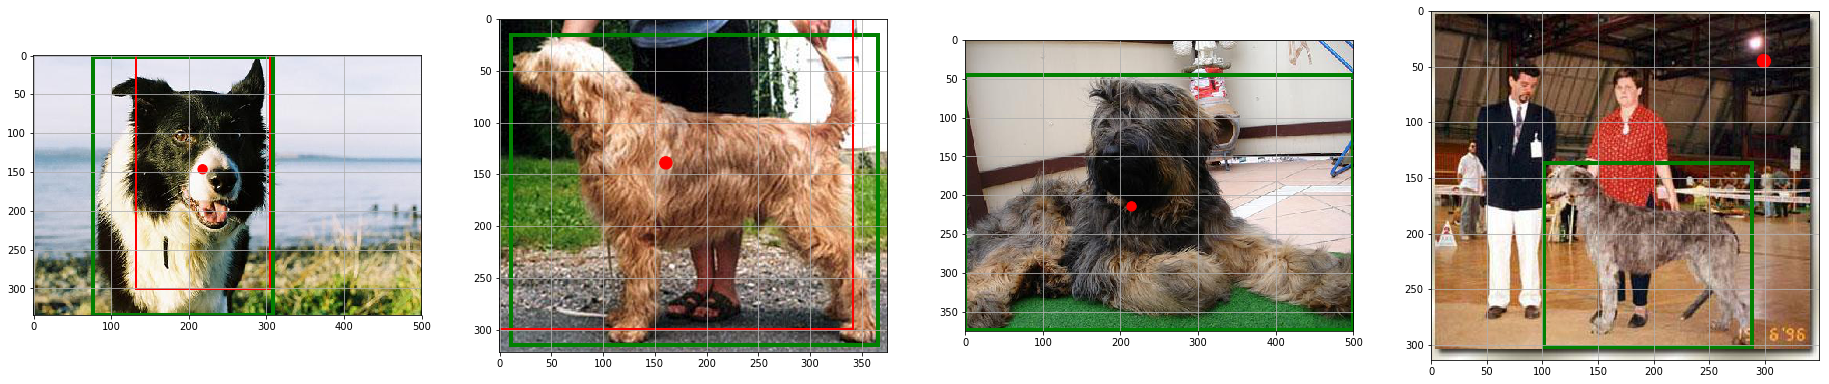

In [14]:
print "eval some train data"
eval(val=False)